## Price Per Square Foot Prediction
In this notebook I predict the price per square foot of a house in Nashville, using an XGBoost. 
Metrics used are root mean squared error, median absolute error, mean absolute error and coefficient of determination.

Since almost all numerical features of the dataset were heavily right-skewed, I have log-transformed every numerical feature except for the target variable (PPS).

I also ran a LightGBMRegressor which got almost identical results, but ran much faster.

### Observations

Quarter and Year are pretty essential variables but I wonder if there's a better way to incorporate time.


### Next step: incorporate data from historical sales.

### Consider adding average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Correcting badly-entered data
df1.loc[176025, 'Sale Price'] = 37000
df1.loc[27056, 'Sale Price'] = 161000
df1.loc[191004, 'Sale Price'] = 810000
df1.loc[239278, 'Sale Price'] = 280395
df1.loc[138891, 'Sale Price'] = 200000
df1.loc[241961, 'Sale Date'] = '2019-03-04'
df1.loc[241961, 'Sale Date'] = pd.to_datetime(df1.loc[241961, 'Sale Date'])
df1.loc[241961, 'Sale Price'] = 370000
df1.loc[230115, 'Sale Price'] = 325000
df1.loc[53151, 'Sale Price'] = 310900
df1.loc[259815, 'Sale Price'] = 1513142
df1.loc[129682, 'Sale Price'] = 1300000
df1.loc[154271, 'Square Footage Improved'] = 10094
df1.drop(190142, inplace=True) #Has a massive ADU ~4 times the size of the 'main' structure. Main struct is low-grade, ADU is luxury.
df1.drop(128094, inplace=True) #Can't find out anything about this house. Improbably large sqft and acreage, low price.

In [4]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()

In [5]:
#Clearing out a few outliers.
#Removing massive parcels of land isn't so much about them being outliers; this model is for urban development.
print(df['Fixtures'].quantile([.97,.985,.995]))
df=df[df.Fixtures <=23]

print(df['Land Area Acres'].quantile([.97,.985,.995]))
df=df[df['Land Area Acres'] <=3]

#Giving PPS more leeway because it's our target variable (and it varies more)
print(df['PPS'].quantile([.97,.985,.997]))
df=df[df.PPS <= 700]

0.970    18.0
0.985    20.0
0.995    24.0
Name: Fixtures, dtype: float64
0.970    1.05
0.985    1.39
0.995    2.47
Name: Land Area Acres, dtype: float64
0.970    359.013753
0.985    434.257306
0.997    591.065269
Name: PPS, dtype: float64


In [6]:
#Log-transforming features because they're heavily right-skewed
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
df['Log NbhdPPS']= df['NeighborhoodPPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
df['Log NbhdRatio']= df['Nbhd Ratio'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)
#Doing a log(n-x) transform, then raising to the 1.5 power because heavily left-skewed
df['Log Built']= df['Year Built'].map(lambda x: np.log(2020-x)**1.5 if (pd.notnull(x) and x != 0) else None).replace(np.inf,np.nan)

## First, checking what the absolute smallest and largest PPS observations are.

In [7]:
df.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
117379,31 N HILL ST,1,10001.0,4.857212,2059.0,SINGLE FAM,Average
87022,5801 MACKIE PL,3,10000.0,6.635700,1507.0,SINGLE FAM,Average
266262,6582 SUNNYWOOD DR,1,15000.0,6.934813,2163.0,SINGLE FAM,Average
210028,4839 JONQUIL DR,1,30000.0,7.812500,3840.0,SINGLE FAM,Average
244774,909 MULBERRY HILL PL,8,28000.0,8.158508,3432.0,SINGLE FAM,Average


In [8]:
df.nlargest(5,'NeighborhoodPPS')[['Neighborhood','NeighborhoodPPS']]

,Neighborhood,NeighborhoodPPS
279631,6264,752.879821
279659,6264,752.879821
279602,6264,752.879821
279617,6264,752.879821
279657,6264,752.879821


## Next, checking the distribution of several numerical features.
I'll end up log-transforming all of these.
'Fixtures' doesn't appear skewed, but the model performs slightly better when it's transformed.

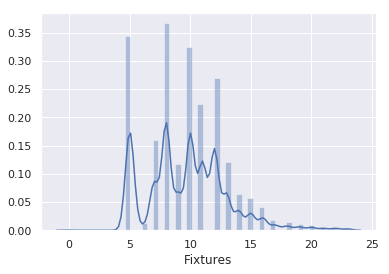

In [9]:
sns.distplot(df['Fixtures'].dropna())

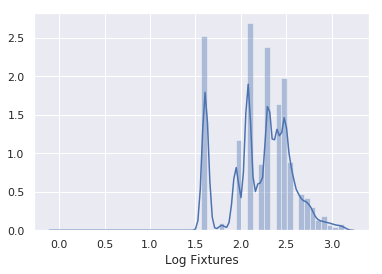

In [10]:
#Not very different, but the model performs slightly better when it's transformed
sns.distplot(df['Log Fixtures'].dropna())

In [11]:
df.nlargest(10, 'Land Area Acres')

,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,...,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land,Log NbhdPPS,Log NbhdRatio,Log Built
13282,RES,"$44,250","$20,250","$64,500",2019.0,3.0,NaN,Fair,NaN,C,...,2,2015,9.915910,2.397895,7.888335,4.540882,1.098612,4.773371,-2.603969,6.861616
207295,RES,"$41,100","$31,250","$72,350",2019.0,2.0,NaN,Average,NaN,C,...,3,2015,10.349775,2.079442,7.604396,5.130915,1.098612,4.934089,-2.912313,7.226057
207292,RES,"$45,450","$31,250","$76,700",2019.0,2.0,NaN,Average,NaN,C,...,3,2016,10.349775,2.079442,7.893572,4.567143,1.098612,4.934089,-2.912313,7.226057
104197,RES,"$91,950","$20,000","$111,950",2019.0,3.0,NaN,Average,NaN,B,...,3,2016,9.903488,2.397895,8.193400,4.482676,1.098612,4.768629,-2.816275,7.966975
207293,RES,"$63,150","$31,250","$94,400",2019.0,4.0,NaN,Average,NaN,C,...,4,2016,10.349775,2.484907,7.813996,5.157545,1.098612,4.934089,-2.912313,7.156288
159948,RES,"$39,775","$18,000","$57,775",2019.0,1.0,NaN,Average,NaN,C,...,4,2016,9.798127,1.945910,7.712444,4.675950,1.098612,4.820341,-2.887247,7.491470
144768,RES,"$95,200","$29,000","$124,200",2019.0,3.0,NaN,Average,NaN,B,...,4,2016,10.275051,2.397895,8.311890,4.800423,1.098612,5.075999,-2.605345,7.491470
82509,COM,"$78,000","$131,720","$209,720",2019.0,3.0,NaN,Average,NaN,C,...,1,2017,11.788434,2.564949,8.050384,4.512488,1.098612,4.512488,-1.381386,7.677665
163232,RES,"$139,550","$29,000","$168,550",2019.0,4.0,NaN,Average,NaN,B,...,2,2017,10.275051,2.833213,8.429891,5.010926,1.098612,5.075999,-2.605345,5.312253
22761,RES,"$21,875","$12,000","$33,875",2019.0,1.0,NaN,Average,NaN,C,...,2,2017,9.392662,1.609438,7.259116,4.754585,1.098612,4.646261,-2.130727,8.334916


## Now to the Machine Learning:

First I'll run a dummy regressor, which just guesses the mean. Then I'll attempt a few different models with increasing accuracy.

In [12]:
#Important metric to keep in mind when judging your model's performance.
np.std(df.PPS)

78.4034438316157

In [13]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error as MSLE

In [14]:
df2 = df[['Log Built','Log NbhdRatio','Building Condition','Log SqFt','Log Fixtures','Building Type Custom','Building Grade','Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 'Year Built', 'Zone']]
df2=df2.dropna()

In [15]:
#dtreeviz doesn't work with features whose names have spaces.
df2.columns = ['Log-Built','Log-NbhdRatio', 'Building-Condition', 'Log-SqFt', 'Log-Fixtures',
       'Building-Type-Custom', 'Building-Grade', 'Exterior-Wall', 'Year',
       'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 'Year-Built', 'Zone']

In [16]:
from sklearn.model_selection import train_test_split
X= pd.get_dummies(df2[['Log-Built','Log-NbhdPPS','Log-NbhdRatio','Log-SqFt','Year','Log-Fixtures', 'Quarter','Building-Grade', 'Building-Type-Custom', 'Log-Assessment']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [17]:
print(df.shape)
print(df2.shape)

(53726, 81)
(53650, 15)


In [18]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_yyytest))**0.5)
print(MSE(y_pred, y_test)**0.5)

80.33107863225332


In [19]:
from sklearn.tree import DecisionTreeRegressor as DTR
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
print(MSE(y_pred, y_test)**0.5)
#Out of the box, this is a decent score. 

41.8576050073977


In [20]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


30.799229449421507


In [21]:
from xgboost import XGBRegressor as XGBR
#Best model parameters from GridSearchCV
model = XGBR(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

xgbr=model.fit(X_train,y_train)
y_predxg=xgbr.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predxg)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predxg)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predxg)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predxg)))
print('Root Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predxg),np.abs(y_test))**0.5))

/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 28.282388074000455
Median Absolute Error: 10.771057391988819
Mean Absolute Error: 17.883903385819217
Coefficient of Determination: 0.8697171217696714
Root Mean Squared Logarithmic Error: 0.1968121123744735


<Figure size 648x648 with 0 Axes>

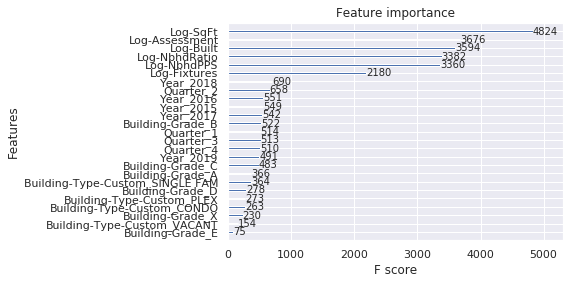

In [22]:
import xgboost as xgb
plt.figure(figsize=(9,9))
xgb.plot_importance(model)

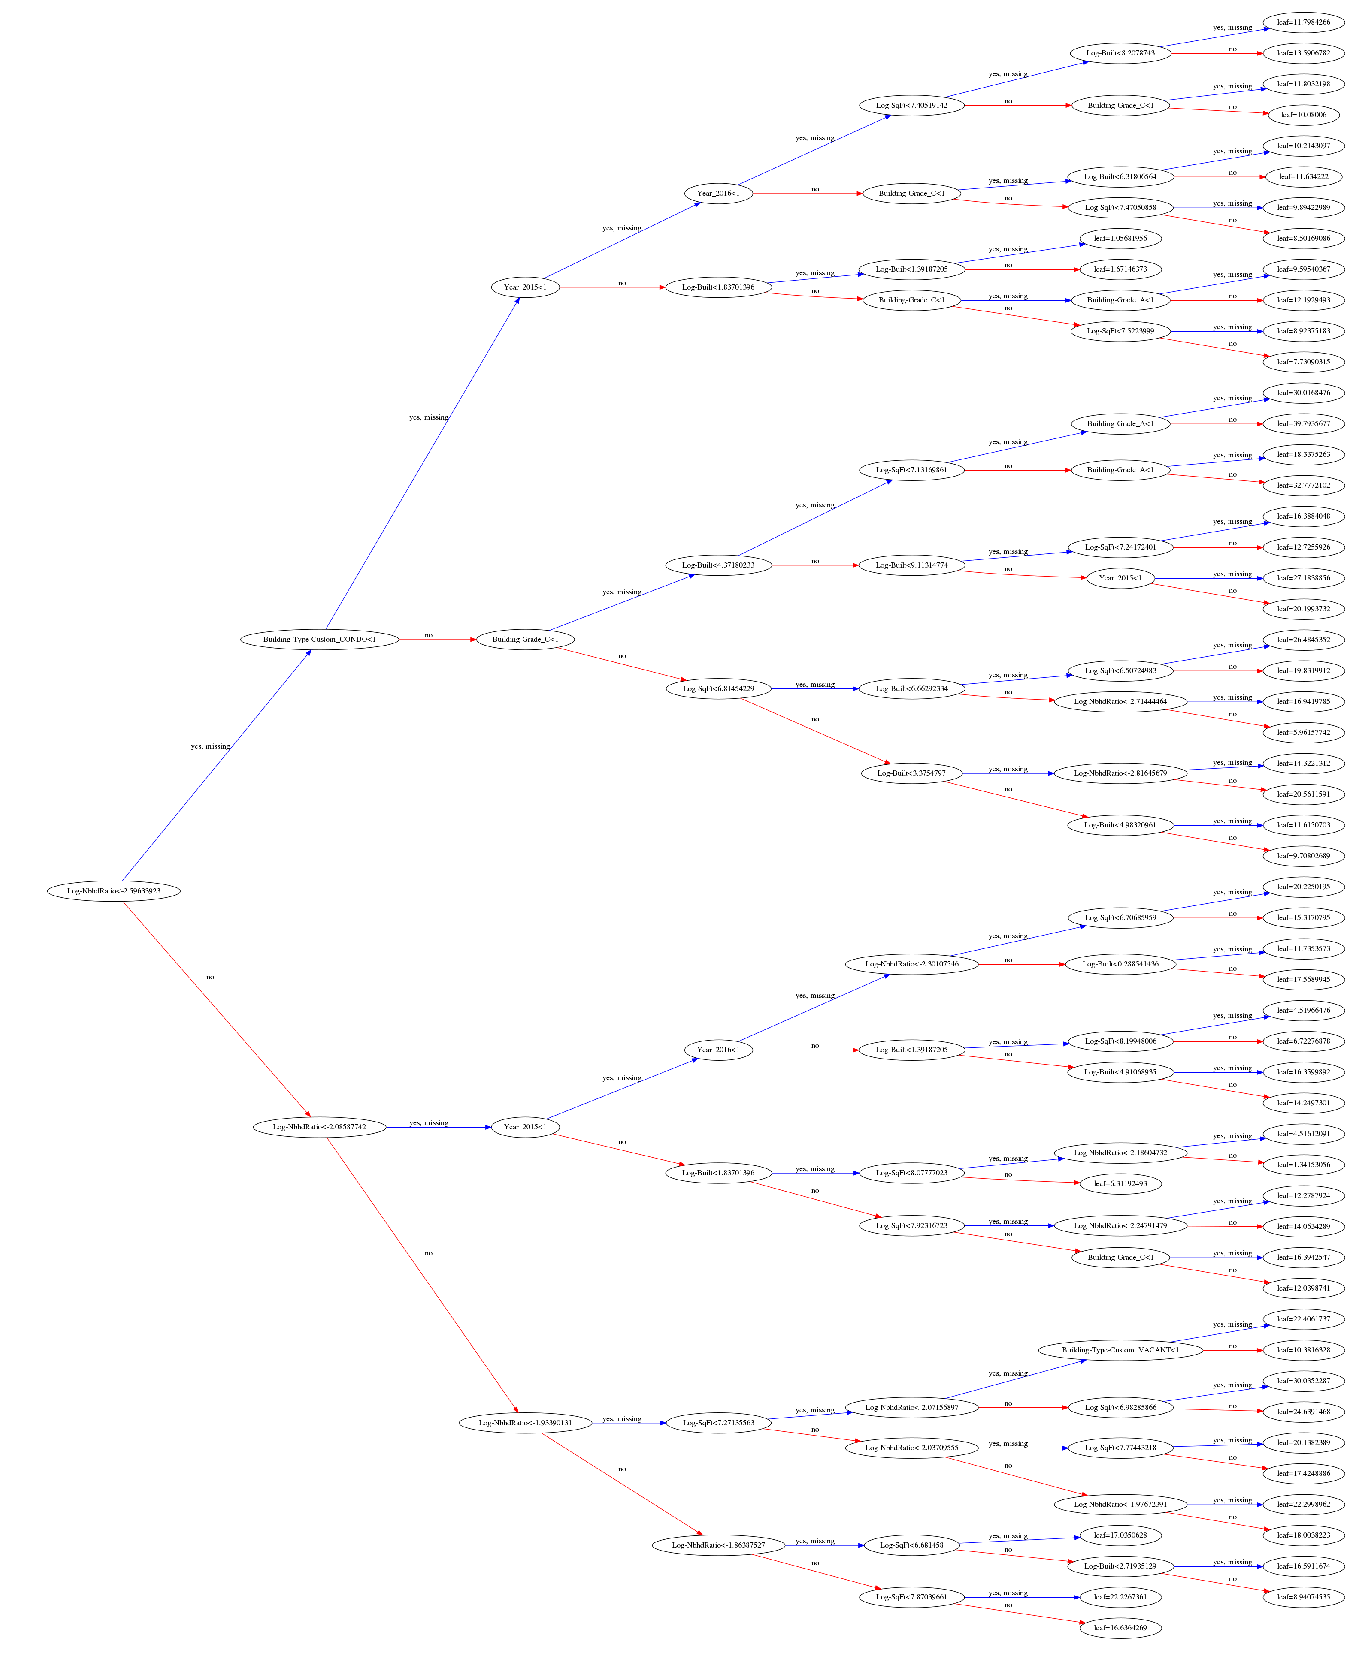

In [23]:
fig, ax = plt.subplots(figsize=(30,30))
xgb.plot_tree(model, ax=ax, rankdir='LR')
plt.show()

### Now testing Microsoft's LightGBM

LightGBM runs much faster (which gives me more time for tuning) and includes some built-in graphing abilities. Performance is generally about the same, but sometimes better than XGBoost, depending on the dataset.

/home/drew/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 17.7083	valid_1's l1: 18.546
[200]	training's l1: 16.4909	valid_1's l1: 17.8839
[300]	training's l1: 15.9682	valid_1's l1: 17.6586
[400]	training's l1: 15.5902	valid_1's l1: 17.5121
[500]	training's l1: 15.314	valid_1's l1: 17.4287
[600]	training's l1: 15.0866	valid_1's l1: 17.3463
[700]	training's l1: 14.8982	valid_1's l1: 17.3003
[800]	training's l1: 14.7247	valid_1's l1: 17.2684
[900]	training's l1: 14.5604	valid_1's l1: 17.2262
[1000]	training's l1: 14.4465	valid_1's l1: 17.2039
RMSE: 28.01780316893554
Median Absolute Error: 9.732646394014893
Mean Absolute Error: 17.203944220052847
Coefficient of Determination: 0.872143341464752
Root Mean Squared Logarithmic Error: 0.18990829906816573


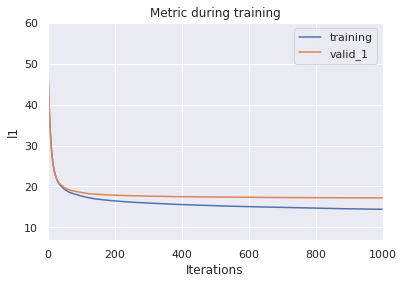

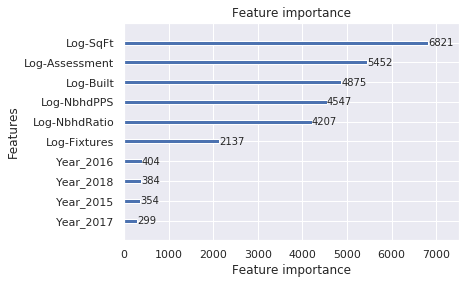

In [24]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test,y_test)
evals_result={}
params = {'objective':'regression_l1', 'max_depth': 6,'reg_alpha':2, 'metric':'l1', 
          'min_child_weight': 40, 'n_estimators': 1000, 'num_leaves': 250}
gbm = lgb.train(params=params,
                train_set= dtrain,
                valid_sets=[dtrain, dvalid],
                evals_result=evals_result,
                verbose_eval=100)
y_predgbm=gbm.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predgbm)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predgbm)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predgbm)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predgbm)))
print('Root Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predgbm),np.abs(y_test))**0.5))
lgb.plot_metric(booster=evals_result)
lgb.plot_importance(gbm, max_num_features=10)

In [25]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()
evals_result={}
param_grid = {
    'learning_rate': [0.18,0.21],
    'n_estimators': [500],
    'min_child_weight':[30,50],
    'max_depth': [5],
    'num_leaves': [350]
    }
params={}
gbm = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
gbm.fit(X_train, y_train)
y_predlgb= gbm.predict(X_test)
print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)
print(MSE(y_test,y_predlgb)**0.5)
print(MAE(y_test,y_predlgb))
print(mean_absolute_error(y_test, y_predlgb))
print(r2_score(y_test, y_predlgb))

Best parameters found by grid search are: {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 500, 'num_leaves': 350}
-820.1916863256973
28.184688596385886
10.725124479931623
17.78861396392709
0.8706156727794498


In [26]:
gbm.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.18, max_depth=5,
       min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=350, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Examining residual errors

In [27]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Residual'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

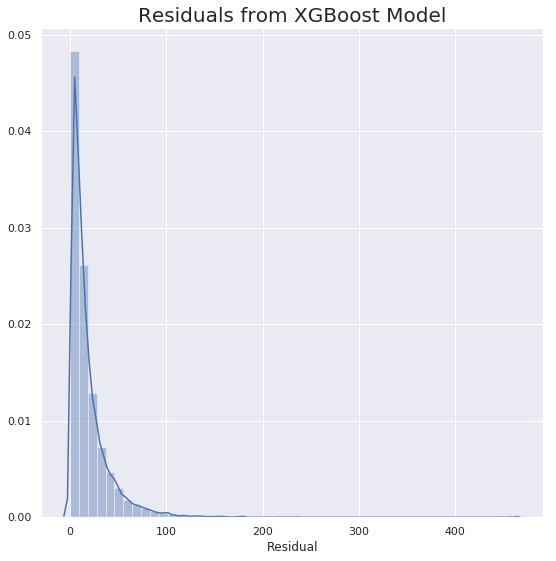

In [28]:
plt.figure(figsize=(9,9))
plt.title('Residuals from XGBoost Model',fontsize=20)
sns.distplot(copiedxg.Residual.dropna())

In [29]:
#The pattern in my biggest flubs is, there's a big difference between the NeighborhoodPPS and the actual PPS
#However, adding NeighborhoodPPS to the model significantly increases performance.
#So how can I tune it to accept NeighborhoodPPS while minimizing this error?
copiedxg.nlargest(15,'Residual')[['Log-NbhdPPS', 'Actual', 'Predicted', 'Residual']]

,Log-NbhdPPS,Actual,Predicted,Residual
249856,6.227716,44.405998,505.670593,461.264596
272462,5.312365,525.986224,209.817123,316.169101
21614,4.650774,72.625698,352.823883,280.198185
261294,5.115802,421.052632,170.612457,250.440174
53693,5.247255,26.808889,263.735962,236.927073
21601,4.650774,24.804469,260.980560,236.176091
153676,5.513594,112.044818,348.059082,236.014264
133785,5.461321,508.905852,281.812744,227.093108
108457,5.570993,66.906005,290.334076,223.428071
116250,5.648999,181.818182,401.167816,219.349634


In [30]:
copiedxg.nlargest(15, 'Residual')[['Actual','Predicted','Residual', 'Log-NbhdPPS']]

,Actual,Predicted,Residual,Log-NbhdPPS
249856,44.405998,505.670593,461.264596,6.227716
272462,525.986224,209.817123,316.169101,5.312365
21614,72.625698,352.823883,280.198185,4.650774
261294,421.052632,170.612457,250.440174,5.115802
53693,26.808889,263.735962,236.927073,5.247255
21601,24.804469,260.980560,236.176091,4.650774
153676,112.044818,348.059082,236.014264,5.513594
133785,508.905852,281.812744,227.093108,5.461321
108457,66.906005,290.334076,223.428071,5.570993
116250,181.818182,401.167816,219.349634,5.648999


In [31]:
copiedlgb= X_test.copy()
copiedlgb['Actual']= y_test
copiedlgb['Predicted']= y_predgbm
copiedlgb['Residual'] = np.absolute(copiedlgb['Actual'] - copiedlgb['Predicted'])
copiedlgb.nlargest(15, 'Residual')

,Log-Built,Log-NbhdPPS,Log-NbhdRatio,Log-SqFt,Log-Fixtures,Log-Assessment,Year_2015,Year_2016,Year_2017,Year_2018,...,Building-Grade_D,Building-Grade_E,Building-Grade_X,Building-Type-Custom_CONDO,Building-Type-Custom_PLEX,Building-Type-Custom_SINGLE FAM,Building-Type-Custom_VACANT,Actual,Predicted,Residual
249856,3.917104,6.227716,-2.821238,6.765039,1.609438,10.052985,0,0,0,1,...,0,0,0,1,0,0,0,44.405998,523.516863,479.110865
272462,0.577083,5.312365,-2.966885,7.375882,2.397895,9.615805,0,0,0,1,...,0,0,0,1,0,0,0,525.986224,218.536055,307.450169
261294,2.398389,5.115802,-2.951219,7.103322,2.302585,9.132379,0,0,1,0,...,0,0,0,1,0,0,0,421.052632,172.534971,248.517660
149823,8.756947,5.402266,-2.047633,7.215240,2.079442,11.630709,0,0,0,1,...,0,0,0,0,0,1,0,547.794118,313.652017,234.142100
86212,7.294401,5.292689,-2.142801,6.745236,1.609438,10.613983,0,0,0,1,...,1,0,0,0,0,1,0,523.529412,296.419667,227.109745
133785,8.667477,5.461321,-2.273863,7.583248,2.079442,11.156251,0,0,1,0,...,0,0,0,0,0,1,0,508.905852,281.899871,227.005981
108457,9.545336,5.570993,-2.062525,7.046647,1.609438,11.002100,1,0,0,0,...,0,0,0,0,0,1,0,66.906005,290.276771,223.370765
53693,8.971121,5.247255,-2.103950,6.802395,1.609438,10.596635,0,0,0,0,...,0,0,0,0,0,1,0,26.808889,249.668926,222.860038
180687,8.022010,5.741161,-1.451399,7.446585,1.945910,11.468346,0,0,1,0,...,0,0,0,0,0,1,0,103.267211,323.117052,219.849841
111003,8.929317,5.502583,-1.970571,7.520776,2.302585,12.771386,0,0,0,1,...,0,0,0,0,1,0,0,487.540628,276.362969,211.177660


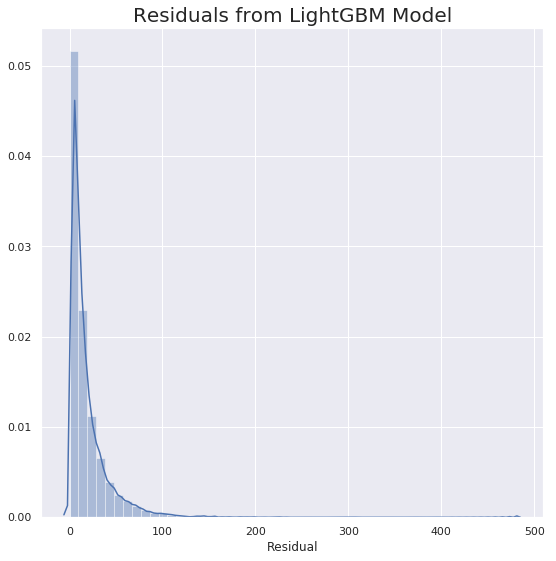

In [32]:
plt.figure(figsize=(9,9))
plt.title('Residuals from LightGBM Model',fontsize=20)
sns.distplot(copiedlgb.Residual.dropna())

## Interpretting the Model

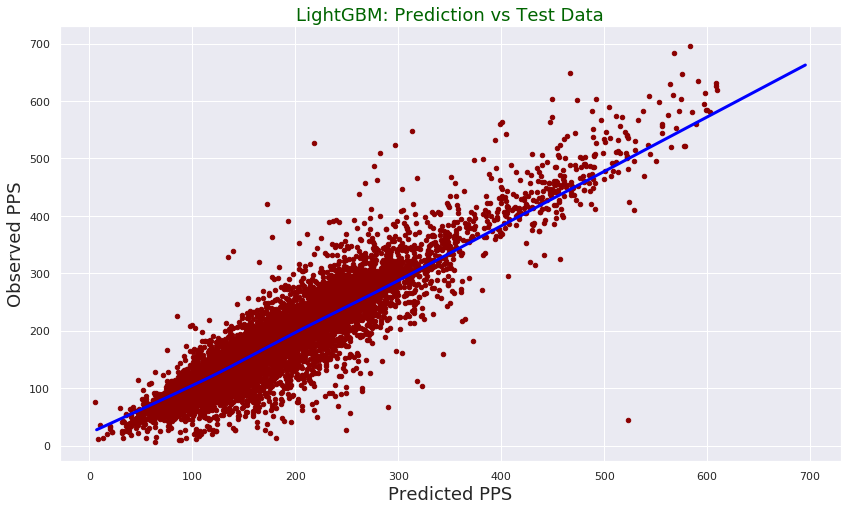

In [33]:
import statsmodels as sm
lowess = sm.nonparametric.smoothers_lowess.lowess
z = lowess(y_predgbm, y_test)
test = pd.DataFrame({"prediction": copiedlgb['Predicted'], "observed": copiedlgb['Actual']})
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("LightGBM: Prediction vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted PPS", fontsize = 18) 
plt.ylabel("Observed PPS", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()

Text(0.5, 0, 'Z: Neighborhood PPS')

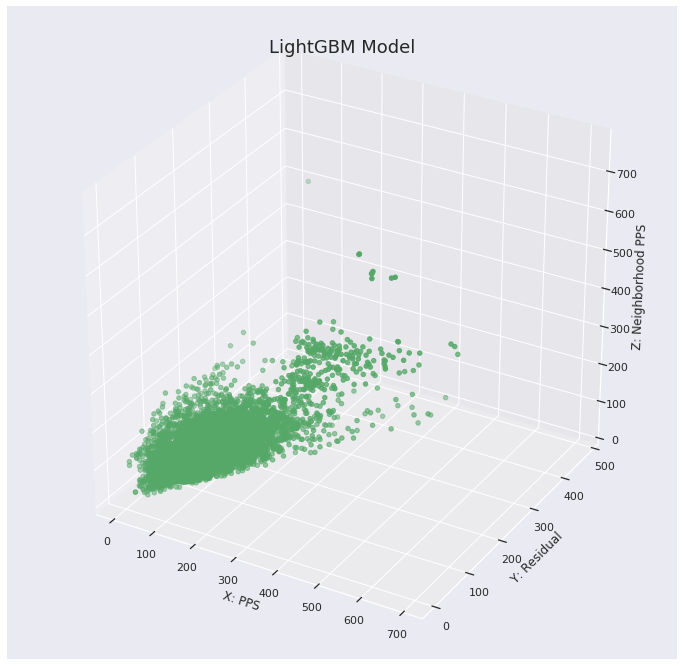

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x =copiedlgb['Actual']
y =copiedlgb['Residual']
z =copiedlgb['Log-NbhdPPS'].map(lambda x: np.exp(x))
plt.title('LightGBM Model', fontsize=18)
ax.scatter(x, y, z, c='g', marker='o')
ax.set_xlabel('X: PPS')
ax.set_ylabel('Y: Residual')
ax.set_zlabel('Z: Neighborhood PPS')

#It looks like the biggest residuals are for houses where the actual PPS was very different from the average PPS in the neighborhood.
#To clarify: these observations are up (high Neighborhood PPS), to the left (low PPS), and back (high residual error)

Text(0.5, 1.0, 'LightGBM Model')

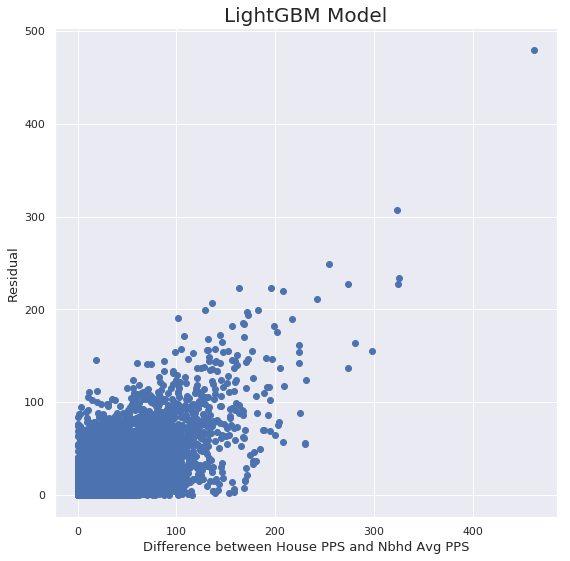

In [35]:
diff = np.abs(copiedlgb['Actual']-copiedlgb['Log-NbhdPPS'].map(lambda x: np.exp(x)))
plt.figure(figsize=(9,9))
plt.scatter(diff,copiedlgb['Residual'])
plt.xlabel('Difference between House PPS and Nbhd Avg PPS', fontsize=13)
plt.ylabel('Residual', fontsize=13)
plt.title('LightGBM Model', fontsize=20)
#So the residual is linearly correlated with how different the house's PPS is from the average PPS in its neighborhood.
#However, NeighborhoodPPS is an important feature in the ML model and performance suffers without it
#To me, this means the NeighborhoodPPS is a good start for a metric, but can be improved (with historical sales data)
#In my next iteration of the model, I'll put in more info about sales in each neighborhood.

## Model Interpretation with SHAP
Features in red pushed the prediction higher, features in blue pushed it lower. 
SHAP visualizes with D3 and GitHub doesn't display JavaScript so I won't add any SHAP plots past these 2 for now.

## Visualize the feature effects for the 200th prediction (chosen as a random example)
## Features in red pushed the prediction higher, blue features pushed it lower.

![title](shap.png)